In [1]:
"""

load the PAGES2k database (2017) downloaded (15/6/23) from 
https://doi.org/10.6084/m9.figshare.c.3285353.v2 
updates the Palmyra record with the one from Feng Zhu's CFR package.  
Then it pares down the metadata to a small subset (configurable) and 
writes that data to a .pkl file for merging with other databases.  
Lucie Luecke 2023/08/01: load_pages2k.py.

Here we use the template (from Julien and Feng's lipd2df notebook) 
to extract a dataframe with the following columns:

columns=['archiveType',
        'climateInterpretation_variable',
        'climateInterpretation_variableDetail',
        'datasetId',
        'dataSetName',                                                                                
        'geo_meanElev', 
        'geo_meanLat', 
        'geo_meanLon',
        'year', 'yearUnits',                                                                                         
        'paleoData_variableName',
        'paleoData_units',                                                                                           
        'paleoData_values',
        'paleoData_notes',
        'paleoData_sensorSpecies',
        'originalDataURL',
        'originalDatabase'
]

We save a standardised compact dataframe for concatenation to form DoD2k

Last updated: 
27/11/24 LL: Changed dD to d2H
21/11/2024 LL: added option to csv saving of compact dataframe, removed redundant output.
10/7/2024 by LL: silenced certain sections, commented on code, added headers and plots

This notebook loads PAGES2k from the source file, updates the Palmyra record via CFR, creates a ‘compact’ dataframe with selected columns and produces a few plots. 

"""

"\n\nload the PAGES2k database (2017) downloaded (15/6/23) from \nhttps://doi.org/10.6084/m9.figshare.c.3285353.v2 \nupdates the Palmyra record with the one from Feng Zhu's CFR package.  \nThen it pares down the metadata to a small subset (configurable) and \nwrites that data to a .pkl file for merging with other databases.  \nLucie Luecke 2023/08/01: load_pages2k.py.\n\nHere we use the template (from Julien and Feng's lipd2df notebook) \nto extract a dataframe with the following columns:\n\ncolumns=['archiveType',\n        'climateInterpretation_variable',\n        'climateInterpretation_variableDetail',\n        'datasetId',\n        'dataSetName',                                                                                \n        'geo_meanElev', \n        'geo_meanLat', \n        'geo_meanLon',\n        'year', 'yearUnits',                                                                                         \n        'paleoData_variableName',\n        'paleoData_units',     

# Set up working environment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gzip
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from matplotlib.gridspec import GridSpec as GS

import cfr

In [4]:
# set up working directory. 
# The default working directory should be the parent folder (compile_proxy_database) so we can access the 'helper' files 
# Make sure this is changing to the correct path!

#wdir = '/home/jupyter-lluecke/compile_proxy_database_v2.0' # working directory, this should work, but doesn't seem to...
if not os.getcwd().endswith('compile_proxy_database_v2.1'):
    os.chdir(os.getcwd()+'/..')
wdir = os.getcwd()
print('working directory: '+wdir)
import functions as f # contains functions for plotting 

working directory: /home/jupyter-lluecke/compile_proxy_database_v2.1


# load the source data and apply corrections

## load main database and auxiliary data

In [5]:
#%% read PAGES 2017 dataset from the pickle file (downloaded from figshare, see readme file)
pickled_PAGES = gzip.open('pages2k/PAGES2k_v2.0.0ts.pklz','r')
read_PAGES    = pd.read_pickle(pickled_PAGES)
df            = pd.DataFrame(read_PAGES) #converts into a DataFrame
print(df.columns.tolist()) # to see all 173 original columns of DataFrame
df.head()

['paleoData_TSid', 'pub1_author', 'pub1_title', 'paleoData_hasResolution', 'geo_pages2kRegion', 'paleoData_proxy', 'paleoData_hasMaxValue', 'pub2_author', 'paleoData_useInGlobalTemperatureAnalysis', 'paleoData_precededBy', 'year', 'paleoData_units', 'geo_country', 'paleoData_values', 'paleoData_hasMeanValue', 'paleoData_hasMinValue', 'paleoData_paleoMeasurementTableMD5', 'pub2_url', 'pub2_citeKey', 'pub2_Urldate', 'yearUnits', 'originalDataURL', 'pub1_citeKey', 'climateInterpretation_interpDirection', 'paleoData_variableName', 'paleoData_hasMedianValue', 'archiveType', 'geo_meanElev', 'chronData_df', 'tagMD5', 'googleDataURL', 'geo_meanLat', 'pub2_DOI', 'metadataMD5', 'dataSetName', 'paleoData_QCCertification', 'pub2_institution', 'paleoData_number', 'dataContributor', '@context', 'climateInterpretation_seasonality', 'climateInterpretation_variable', 'pub2_title', 'geo_type', 'geo_siteName', 'paleoData_pages2kID', 'pub1_pubYear', 'climateInterpretation_variableDetail', 'paleoData_senso

,paleoData_TSid,pub1_author,pub1_title,paleoData_hasResolution,geo_pages2kRegion,paleoData_proxy,paleoData_hasMaxValue,pub2_author,paleoData_useInGlobalTemperatureAnalysis,paleoData_precededBy,...,pub5_citeKey,pub4_publisher,pub6_citeKey,modernSystem_instrumentalDatasetCoordinates,pub1_year,geo_province,funding6_grant,paleoData_useInNAm2kHydro,funding5_agency,pub2_abstract
0,NAm_3004,NEEDS AUTHORS,NEEDS A TITLE!,"{'hasMedianValue': 1.0, 'hasMaxValue': 1.0, 'v...",NAm,TRW,2.194,"Graybill, D.A",TRUE,NAm-TR_105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LPD30c5b95c,"Newton, A. and Thunell, R. and Stott, L",Changes in the Indonesian Throughflow during t...,"{'hasMedianValue': -13.977272000000085, 'hasMa...",Ocean,foram Mg/Ca,29.540,"McGregor, Helen V. and Evans, Michael N. and G...",TRUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NAm_3819,"Gajewski, K",Late holocene climate changes in eastern North...,"{'hasMedianValue': 17.5, 'hasMaxValue': 43.0, ...",NAm,pollen,20.600,NEEDS AUTHORS,TRUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Asia_221,"Cook, Edward R. and Krusic, Paul J. and Anchuk...",Tree-ring reconstructed summer temperature ano...,"{'hasMedianValue': 1.0, 'hasMaxValue': 1.0, 'v...",Asia,TRW,1.636,NEEDS AUTHORS,TRUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Asia_153,"Cook, E. R. and Anchukaitis, K. J. and Buckley...",Asian Monsoon Failure and Megadrought During t...,"{'hasMedianValue': 1.0, 'hasMaxValue': 1.0, 'v...",Asia,TRW,1.983,NEEDS AUTHORS,TRUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
79*2

158

In [7]:
count =0
for ii in df.isna().sum():
    if ii/len(df)*100>85:
        count+=1
print(count)
print(count/len(df.columns))

88
0.5086705202312138


saved figure in /pages2k///pages2k_CFR_spatial.pdf


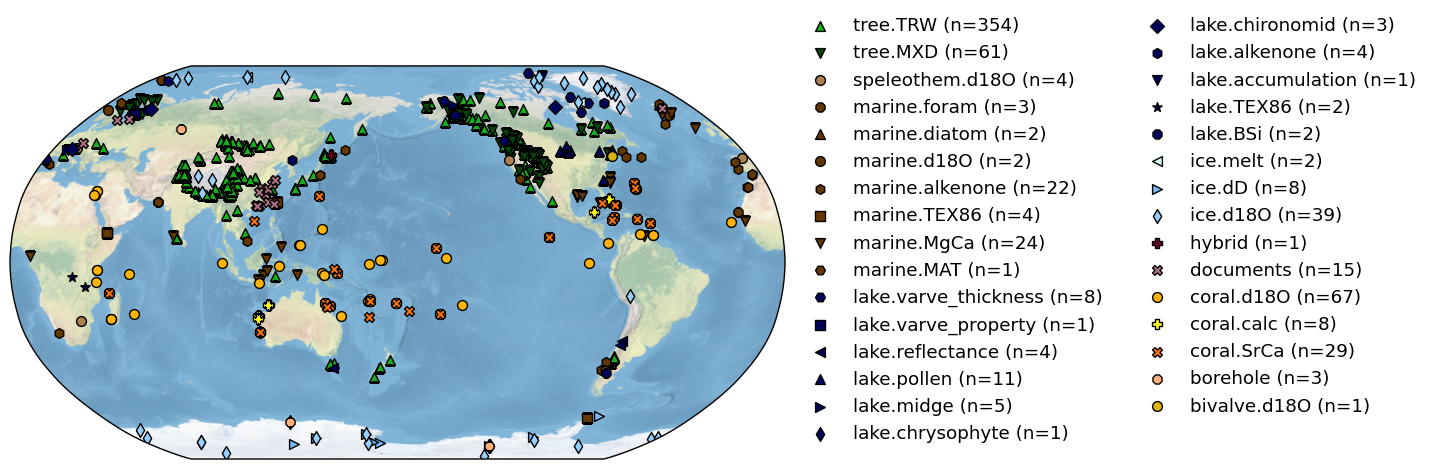

In [8]:
#%% ===========================================================================
# the following cells compare the PAGES2k data from figshare (used above and stored in df)
# with another version provided by Feng Zhu's cfr environment, which 
# we believe contains an updated record. The cfr doc can be found here:
# (https://fzhu2e.github.io/cfr/)

# load data remotely from cfr
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')
job.proxydb 

pdb    = cfr.ProxyDatabase().fetch('PAGES2kv2')  #cfr.ProxyDatabase().from_df(df)
df_cfr = pdb.to_df() # convert cfr object to pandas dataframe
#print(df_cfr.info())
# plot the ProxyDatabase object (similar to plot above)
fig, ax = pdb.plot()
f.figsave(fig, 'pages2k_CFR_spatial', addfigs='/pages2k/')

## compare data from both databases and update main database

In [9]:
#%% compare the data from cfr with the data from figshare

# check the pages ID's are all the same:
check_keys = []
for key in df['paleoData_pages2kID']:
    if key in df_cfr['pid'].values: 
        check_keys += [True]
    else:                    
        check_keys += [False]
if np.all(check_keys):
    print('Found all keys in the CFR version which are in the figshare version')
else:
    print('There are differences in the two databases!')
    

Found all keys in the CFR version which are in the figshare version


In [10]:
# So the IDs all match. However one record is updated in cfr which might not be in PAGES2k?

#%% check for updated Palmyra record in the data downloaded from figshare (df)
rr, cc = np.where(df=='Palmyra')
# rr is rows and cc is columns
# Palmyra is in column 44, which is: geo_siteName
# print(df.columns[cc[0]])
#print(df.iloc[rr[0]])
#print(cc)
# found 2 sites with this names, and IDs: 
# Ocean2kHR_161 (Nurhati, Intan S. and Cobb, Kim M. and Di Lorenzo, Emanuel) 
# and Ocean2kHR_139 (Cobb, Kim M. and Charles, Christopher D. and Cheng, Hai and Edwards, R. Lawrenc)
palmyra = []
for record in rr:
    #print(df.iloc[record][['paleoData_pages2kID', 'pub1_author', 'geo_siteName']])
    palmyra.append(df.iloc[record]['paleoData_pages2kID'])
#print(palmyra)
    

In [11]:
# so it turns out that the record on CFR includes an additional section for Ocn_103!
# write it into the DataFrame, to make sure the updated version is used. 
#%% update the Palmyra record in df (figshare Data)

index = df[df['paleoData_pages2kID']==palmyra[1]].index[0]
# print(index)
df.at[index, 'paleoData_values'] = df_cfr['value'][df_cfr['pid']==palmyra[1]].values[0]
df.at[index, 'year'] = df_cfr['time'][df_cfr['pid']==palmyra[1]].values[0]


In [12]:
# save the updated DataFrame (df) as pickle:
# df.to_pickle('pages2k/PAGES2kv2_updatedPalmyra.pkl')

# create compact dataframe

## define compact dataframe and choose subset of columns 

In [13]:
# copy and paste all the columns in the pages dataframe.
# choose the relevant keys:

list_of_vars = ['paleoData_TSid', # =  ID (unique identifier)
                #'paleoData_pages2kID', # = PAGES 2k ID (unique identifier)
                'paleoData_proxy', 'archiveType', # = proxy type and archive type
                'year', 'yearUnits', # = time and time units
                'paleoData_values', # the actual data
                'paleoData_units', # = data and data units
                #'geo_country', # = country
                'geo_siteName', # = site name
                'geo_meanElev', 'geo_meanLat', 'geo_meanLon', # = elevation, latitude and longitude (mean)
                #'climateInterpretation_seasonality', # = seasonal sensitivity
                'climateInterpretation_variable', # = all records are sensitive to T(emperature)
                'climateInterpretation_variableDetail', # = sensitive to e.g. air or sea surface
                #pub1_author',  'pub1_title', #'pub1_pubYear', 'pub1_year', 
                #'paleoData_hasResolution', #'geo_pages2kRegion', # not needed
                #'paleoData_hasMaxValue', 'paleoData_hasMeanValue', 'paleoData_hasMedianValue', 'paleoData_hasMinValue',# not needed
                # 'paleoData_useInGlobalTemperatureAnalysis', ???
                # 'paleoData_precededBy', # not needed
                 # 'paleoData_paleoMeasurementTableMD5', 'metadataMD5', #?????
                 #'pub2_author', 'pub2_url', 'pub2_citeKey', 'pub2_DOI', 'pub2_title', #'pub2_Urldate', 
                 'originalDataURL', #'pub1_citeKey', 
                 # 'climateInterpretation_interpDirection', 
                 # 'paleoData_variableName',#
                 # 'chronData_df', 'tagMD5', 'googleDataURL', ???
                 'dataSetName', # = name of original dataset?
                 # 'paleoData_QCCertification', #'pub2_institution', 
                 # 'paleoData_number', 'dataContributor',# '@context',
                  'paleoData_sensorSpecies',
                #'googleMetadataWorksheet',
                 # 'climateInterpretation_basis', 'pub2_type',
                 #'WDCPaleoUrl', #'googleSpreadSheetKey', 
                 # 'investigators', 'calibration_uncertaintyType',
                 # 'paleoData_ocean2kID', 'pub3_url', 'paleoData_inCompilation', 
                 # 'pub3_citeKey', 'studyName', 'chronData',
                 # 'calibration_uncertainty', 'notes', 
                 # 'paleoData_measurementMaterial',
                 # 'pub3_Urldate', 'pub1_publisher', 
                 #'paleoData_dataType', 
                 #'pub2_dataUrl', 'pub1_journal', 'pub2_pubYear', 
                 # 'LiPDVersion', 
                  #'geo_type',  ?
                 'paleoData_notes'#, 'pub2_publisher', 'paleoData_iso2kUI',
                 # 'paleoData_uncertainty', 'pub1_issue', 'depthUnits', 'pub3_author', 
                 # 'collectionName', 'paleoData_QCnotes', 'pub3_institution',
                 # 'pub2_issue', 'pub2_volume', 'funding1_agency', 'pub1_dataUrl',
                 # 'pub2_pages', 'pub1_pages', 'pub1_DOI', 'calibration_notes',
                 # 'pub2_journal', 'pub3_type', 'paleoData_measurementMethod', 
                 # 'pub1_volume', 'pub3_title', 'calibration_reference',
                 # 'calibration_equation', 'paleoData_description', 'pub1_type', 
                 #'geo_state', # not needed
                 #'ageUnits', 'age',  # majority nans
                 #'pub3_DOI', 
                # 'geo_ocean',  #'geo_region','geo_province', all NaNs??
                 # 'paleoData_sensorGenus', Nans?
                 #'paleoData_detail',# all NaNs:??
                 # 'funding1_grant', 'funding2_agency', 'funding2_grant', 
                 # 'pub1_link',
                 # 'pub1_institution', 'pub1_pubDataUrl', 'pub1_url', 'pub2_pubDataUrl', 
                 # 'funding3_agency', 'funding5_grant', 'funding4_grant', 
                 # 'funding3_grant', 'pub4_institution', 'pub4_url', 'pub4_type',
                 # 'pub3_pubYear', 'pub4_title', 'pub4_Urldate', 'pub4_author',
                 # 'pub4_citeKey', 'pub1_abstract',
                 #'ageMax', 'ageMaxUnits', 'ageMinUnits', 'ageMin',
                 # 'funding4_agency', 'pub6_author',
                 # 'pub3_dataUrl', 'pub5_author', 'pub6_type', 'pub5_pages', 
                 # 'pub5_volume', 'pub3_publisher', 'pub4_volume', 'pub5_type',
                 # 'pub4_DOI', 'pub5_publisher', 'pub5_pubYear', 'pub5_DOI',
                 # 'pub4_dataUrl', 'pub4_pages', 'pub6_title', 'pub3_volume',
                 # 'pub5_dataUrl', 'pub4_pubYear', 'pub3_journal', 'pub5_issue',
                 # 'pub6_Urldate', 'pub3_pages', 'pub5_title', 'pub4_journal',
                 # 'pub6_url', 'pub5_journal', 'pub6_institution', 'pub5_citeKey',
                 # 'pub4_publisher', 'pub6_citeKey', 
                 #'modernSystem_instrumentalDatasetCoordinates', 
                 #'funding6_grant', 'paleoData_useInNAm2kHydro', 
                 #'funding5_agency', 'pub2_abstract'
                ]

In [14]:
# create smaller dataframe with specific columns which we want to keep for the concatenated database
df_compact=df[list_of_vars]
print(df_compact.keys())

Index(['paleoData_TSid', 'paleoData_proxy', 'archiveType', 'year', 'yearUnits',
       'paleoData_values', 'paleoData_units', 'geo_siteName', 'geo_meanElev',
       'geo_meanLat', 'geo_meanLon', 'climateInterpretation_variable',
       'climateInterpretation_variableDetail', 'originalDataURL',
       'dataSetName', 'paleoData_sensorSpecies', 'paleoData_notes'],
      dtype='object')


## rename columns and entries according to standard terminology

In [15]:
# rename paleoData_TSid to 'datasetId'
df_compact=df_compact.rename(columns={"paleoData_TSid": "datasetId"})
df_compact['originalDatabase'] = 'PAGES2k v2.0.0 (Ocn_103 updated with Dee et al. 2020)'
df_compact['yearUnits']        = 'CE'
print(df_compact.keys())

Index(['datasetId', 'paleoData_proxy', 'archiveType', 'year', 'yearUnits',
       'paleoData_values', 'paleoData_units', 'geo_siteName', 'geo_meanElev',
       'geo_meanLat', 'geo_meanLon', 'climateInterpretation_variable',
       'climateInterpretation_variableDetail', 'originalDataURL',
       'dataSetName', 'paleoData_sensorSpecies', 'paleoData_notes',
       'originalDatabase'],
      dtype='object')


In [16]:
for ii in df_compact.index:
    year = np.array(df_compact.at[ii, 'year'], dtype=float)
    vals = np.array(df_compact.at[ii, 'paleoData_values'], dtype=float)
    df_compact.at[ii, 'year']             = year[year>=1]
    df_compact.at[ii, 'paleoData_values'] = vals[year>=1]

In [17]:
# rename certain proxy types to follow standard terminology
df_compact.loc[df_compact['paleoData_proxy']=='Coral Sr/Ca', 'paleoData_proxy']='Sr/Ca'
df_compact.loc[df_compact['paleoData_proxy']=='dD', 'paleoData_proxy']='d2H'
df_compact.loc[df_compact['paleoData_proxy']=='delta Density', 'paleoData_proxy']='MXD'
df_compact.loc[df_compact['paleoData_proxy']=='planktonic foraminifera', 'paleoData_proxy']='foraminifera'
print(np.sort(np.unique(df_compact['paleoData_proxy'].values)))

['BSi' 'Documentary' 'MXD' 'Sr/Ca' 'TEX86' 'TRW' 'alkenone' 'borehole'
 'calcification' 'calcification rate' 'chironomid' 'chrysophyte' 'd18O'
 'd2H' 'diatom' 'dynocist MAT' 'foram Mg/Ca' 'foram d18O' 'foraminifera'
 'historic' 'hybrid' 'melt' 'midge' 'pollen' 'reflectance'
 'sed accumulation' 'varve property' 'varve thickness']


In [18]:
# replace reference to 'this study' with proper DOI
df_compact.loc[df_compact['originalDataURL']=='this study', 'originalDataURL']='https://doi.org/10.6084/m9.figshare.c.3285353.v2'


In [19]:
# homogneise missing values for str columns
df_compact.loc[df_compact['paleoData_units']=='NA', 'paleoData_units']='N/A'
df_compact.loc[df_compact['paleoData_units']=='NaN', 'paleoData_units']='N/A'
df_compact.loc[df_compact['paleoData_units']=='NA', 'paleoData_units']='N/A'
df_compact.loc[df_compact['paleoData_units']=='NaN', 'paleoData_units']='N/A'



In [20]:
df['paleoData_sensorSpecies'] = df['paleoData_sensorSpecies'].map(lambda x: np.array(x, dtype = str))
df_compact.loc[df_compact['paleoData_sensorSpecies']=='NA', 'paleoData_sensorSpecies']='N/A'
df_compact.loc[pd.isnull(df_compact['paleoData_sensorSpecies']), 'paleoData_sensorSpecies']='N/A'

df_compact.loc[df_compact['paleoData_notes']=='NA', 'paleoData_notes']='N/A'
df_compact.loc[pd.isnull(df_compact['paleoData_notes']), 'paleoData_notes']='N/A'

In [21]:

df_compact.loc[df_compact['climateInterpretation_variable']=='T', 'climateInterpretation_variable']='temperature'

In [22]:
#  check that the datasetId is unique 
print(len(df_compact.datasetId.unique()))
print(len(df_compact))
# make datasetId unique by simply adding index number
df_compact.datasetId=df_compact.apply(lambda x: 'pages2k_'+x.datasetId, axis=1)
# check uniqueness - problem solved.
print(len(df_compact.datasetId.unique()))

692
692
692


In [23]:
# mask nans and exclude from dataframe
for ii in df_compact.index:
    dd=f.convert_to_nparray(df_compact.at[ii, 'paleoData_values'])
    df_compact.at[ii, 'paleoData_values']=dd.data[~dd.mask]
    df_compact.at[ii, 'year']=df_compact.at[ii, 'year'][~dd.mask]
    
drop_inds = []
for ii in range(df_compact.shape[0]):
    if len(df_compact.iloc[ii]['year'])==0:
        print('empty', ii, df_compact.iloc[ii]['year'], df_compact.iloc[ii]['originalDatabase'])
        print(df_compact.iloc[ii]['paleoData_values'])
        drop_inds += [df_compact.index[ii]]
        
for ii, row in enumerate(df_compact.paleoData_values):
    if np.std(row)==0: 
        print(ii, 'std=0')
    elif np.sum(np.diff(row)**2)==0: 
        print(ii, 'diff=0')
    elif np.isnan(np.std(row)):
        print(ii, 'std nan')
    else:
        continue
    if df.index[ii] not in drop_inds: 
        drop_inds += [df_compact.index[ii]]
    
print(drop_inds)
df_compact = df_compact.drop(index=drop_inds)

[]


## save compact dataframe

In [24]:
df_compact = df_compact[sorted(df_compact.columns)]
print(df_compact.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   archiveType                           692 non-null    object 
 1   climateInterpretation_variable        692 non-null    object 
 2   climateInterpretation_variableDetail  692 non-null    object 
 3   dataSetName                           692 non-null    object 
 4   datasetId                             692 non-null    object 
 5   geo_meanElev                          692 non-null    float64
 6   geo_meanLat                           692 non-null    float64
 7   geo_meanLon                           692 non-null    float64
 8   geo_siteName                          692 non-null    object 
 9   originalDataURL                       692 non-null    object 
 10  originalDatabase                      692 non-null    object 
 11  paleoData_notes    

### save pickle

In [25]:
# save to a pickle file (security: is it better to save to csv?)
# sort columns alphabetically (so they all appear in same order across the compact dataframes, for easy comparison)

df_compact.to_pickle('pages2k/pages2k_compact.pkl')

### save csv

In [26]:
# save to a list of csv files (metadata, data, year)
df_compact.name='pages2k'
f.write_compact_dataframe_to_csv(df_compact)

METADATA: archiveType, climateInterpretation_variable, climateInterpretation_variableDetail, dataSetName, datasetId, geo_meanElev, geo_meanLat, geo_meanLon, geo_siteName, originalDataURL, originalDatabase, paleoData_notes, paleoData_proxy, paleoData_sensorSpecies, paleoData_units, yearUnits
Saved to /home/jupyter-lluecke/compile_proxy_database_v2.1/pages2k/pages2k_compact_%s.csv


In [27]:
# load dataframe
f.load_compact_dataframe_from_csv('pages2k').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   archiveType                           692 non-null    object 
 1   climateInterpretation_variable        692 non-null    object 
 2   climateInterpretation_variableDetail  692 non-null    object 
 3   dataSetName                           692 non-null    object 
 4   datasetId                             692 non-null    object 
 5   geo_meanElev                          692 non-null    float32
 6   geo_meanLat                           692 non-null    float32
 7   geo_meanLon                           692 non-null    float32
 8   geo_siteName                          692 non-null    object 
 9   originalDataURL                       692 non-null    object 
 10  originalDatabase                      692 non-null    object 
 11  paleoData_notes    

# check output

## dataset metadata: dataSetName, datasetId, originalDataURL, originalDatabase

### index

In [28]:
# # check index
print(df_compact.index)

RangeIndex(start=0, stop=692, step=1)


### dataSetName

In [29]:
# # check dataSetName
key = 'dataSetName'
print('%s: '%key)
print(df_compact[key].values)

dataSetName: 
['NAm-nv512' 'O2kLR-MakassarStrait-MD98-2177.Newton.2011'
 'NAm-Little_Pine_L' 'Asia-QAMDJT' 'Asia-ONONLS' 'Asia-GOUQIN'
 'Asia-SHIYAT' 'NAm-cana352' 'NAm-mt119' 'NAm-mt108' 'NAm-mt108'
 'Ocean2kHR-PacificSuvaBagnato2005' 'Aus-MtRead.Cook.2006'
 'Arc-Yamalia.Briffa.2013' 'Asia-SouthChina.Wang.1998'
 'O2kLR-MakassarStrait.Linsley.2010' 'SAm-LagunaChepical.deJong.2013'
 'NAm-wa081' 'Asia-ZhejiangandF.Zhang.1980' 'Arc-SoperLakeBaf.Hughen.2000'
 'Ant-SiteDML07.Graf.2000' 'Arc-MD992275.Jiang.2005'
 'O2kLR-ArabianSea.Doose-Rolinski.2001' 'Ant-DomeF.Horiuchi.2008'
 'NAm-cana113' 'Asia-BIARLS' 'Asia-HORBLS' 'Arc-Luoto2009'
 'SAm-CAN11.Neukom.2011' 'Asia-BULGLS' 'Aus-StewartIslan.DArrigo.1995'
 'NAm-cana437' 'Ocean2kHR-PacificLinsley2006Rarotongad18O2R' 'Asia-KOKKIY'
 'NAm-ca534' 'NAm-mt116' 'Ocean2kHR-AtlanticBiscayneBaySwart1996'
 'Arc-BrayaSo.DAndrea.2011' 'Ant-PlateauRemot.Cole-Dai.1996'
 'O2kLR-Minorca.Moreno.2012' 'Asia-YKC' 'Arc-ScreamingLynx.Clegg.2011'
 'Ocean2kHR-Atlanti

### datasetId

In [30]:
# # check datasetId

print(len(df_compact.datasetId.unique()))
print(len(df_compact))
key = 'datasetId'
print('%s (starts with): '%key)
print(df_compact[key].values)

692
692
datasetId (starts with): 
['pages2k_NAm_3004' 'pages2k_LPD30c5b95c' 'pages2k_NAm_3819'
 'pages2k_Asia_221' 'pages2k_Asia_153' 'pages2k_Asia_044'
 'pages2k_Asia_130' 'pages2k_NAm_1852' 'pages2k_NAm_2824'
 'pages2k_NAm_2740' 'pages2k_NAm_2752' 'pages2k_Ocean2kHR_142'
 'pages2k_Aus_041' 'pages2k_Arc_100' 'pages2k_Asia_319'
 'pages2k_O2kLR_135' 'pages2k_SAm_025' 'pages2k_NAm_3436'
 'pages2k_Asia_327' 'pages2k_Arc_076' 'pages2k_Ant_006' 'pages2k_Arc_045'
 'pages2k_O2kLR_114' 'pages2k_Ant_010' 'pages2k_NAm_1360'
 'pages2k_Asia_142' 'pages2k_Asia_146' 'pages2k_Arc_048' 'pages2k_can1101'
 'pages2k_Asia_143' 'pages2k_Aus_067' 'pages2k_NAm_2152'
 'pages2k_Ocean2kHR_147' 'pages2k_Asia_137' 'pages2k_NAm_664'
 'pages2k_NAm_2812' 'pages2k_Ocean2kHR_118' 'pages2k_Arc_042'
 'pages2k_Ant_023' 'pages2k_LPD10e9f8f7' 'pages2k_Asia_119'
 'pages2k_Arc_041' 'pages2k_Ocean2kHR_128' 'pages2k_Ocean2kHR_129'
 'pages2k_Asia_216' 'pages2k_Eur_002' 'pages2k_NAm_976'
 'pages2k_Ocean2kHR_022' 'pages2k_NAm_200

### originalDataURL

In [31]:
# originalDataURL
key = 'originalDataURL'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))
# 'this study' should point to the correct URL (PAGES2k)

originalDataURL: 
['ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/came2007/came2007.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/harada2004/harada2004.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/keigwin2003/keigwin2003.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/keigwin2005'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/lamy2002/'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/linsley2010/linsley2010.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/lund2006/lund2006.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/richter2009/richter2009.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/saraswat2013/saraswat2013-sk237gc04.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/thornalley2009/thornalley2009.txt'
 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/coral/caribbean/turrumote2008.t

### originalDatabase

In [32]:
# # originalDataSet
key = 'originalDatabase'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))
# Note: the last two records have missing URLs

originalDatabase: 
['PAGES2k v2.0.0 (Ocn_103 updated with Dee et al. 2020)']


## geographical metadata: elevation, latitude, longitude, site name

### geo_meanElev

In [33]:
# check Elevation
key = 'geo_meanElev'
print('%s: '%key)
print(df_compact[key])
print(np.unique(['%d'%kk for kk in df_compact[key] if np.isfinite(kk)]))

geo_meanElev: 
0      3170.0
1      -968.0
2       330.0
3      3150.0
4      1700.0
        ...  
687    3800.0
688     725.0
689    3300.0
690    2250.0
691    2500.0
Name: geo_meanElev, Length: 692, dtype: float64
['-1' '-10' '-1011' '-1022' '-1048' '-11' '-1108' '-1169' '-1185' '-12'
 '-1205' '-1245' '-125' '-1274' '-1295' '-13' '-136' '-14' '-143' '-1491'
 '-1497' '-1570' '-1598' '-16' '-1648' '-18' '-1895' '-1938' '-2' '-20'
 '-2114' '-2224' '-2259' '-2263' '-2303' '-2382' '-2394' '-25' '-250'
 '-2543' '-2630' '-2793' '-3' '-30' '-330' '-355' '-3975' '-4' '-450'
 '-470' '-5' '-503' '-510' '-530' '-531' '-547' '-590' '-594' '-6' '-620'
 '-694' '-695' '-7' '-790' '-8' '-80' '-817' '-852' '-869' '-875' '-9'
 '-900' '-96' '-968' '-97' '0' '1' '10' '100' '1000' '1020' '103' '1040'
 '1054' '106' '110' '1100' '1110' '1128' '1167' '1200' '124' '1250' '1275'
 '130' '1300' '1330' '1350' '1354' '1370' '14' '140' '1400' '1450' '1465'
 '1495' '150' '1500' '1530' '1542' '1550' '160' '1600' '16

### geo_meanLat

In [34]:
# # Latitude
key = 'geo_meanLat'
print('%s: '%key)
print(np.unique(['%d'%kk for kk in df_compact[key]]))

geo_meanLat: 
['-1' '-10' '-12' '-13' '-15' '-16' '-17' '-18' '-19' '-2' '-21' '-22'
 '-23' '-24' '-28' '-29' '-3' '-32' '-33' '-38' '-39' '-4' '-40' '-41'
 '-42' '-43' '-44' '-45' '-47' '-5' '-6' '-64' '-66' '-7' '-70' '-72'
 '-74' '-75' '-77' '-78' '-79' '-8' '-84' '-86' '0' '1' '10' '11' '12'
 '13' '16' '17' '18' '19' '2' '20' '21' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '5' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '6' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '7' '70'
 '71' '72' '73' '75' '76' '77' '78' '79' '8' '80' '81' '82']


### geo_meanLon

In [35]:
# # Longitude 
key = 'geo_meanLon'
print('%s: '%key)
print(np.unique(['%d'%kk for kk in df_compact[key]]))

geo_meanLon: 
['-10' '-103' '-105' '-106' '-107' '-109' '-110' '-111' '-112' '-113'
 '-114' '-115' '-116' '-117' '-118' '-119' '-120' '-121' '-122' '-123'
 '-125' '-127' '-128' '-13' '-131' '-132' '-133' '-134' '-135' '-136'
 '-138' '-139' '-140' '-141' '-142' '-143' '-145' '-146' '-147' '-148'
 '-149' '-150' '-152' '-157' '-159' '-16' '-162' '-17' '-174' '-18' '-19'
 '-22' '-24' '-26' '-27' '-3' '-36' '-37' '-38' '-4' '-41' '-42' '-43'
 '-45' '-50' '-54' '-57' '-60' '-61' '-62' '-64' '-65' '-66' '-67' '-68'
 '-69' '-70' '-71' '-72' '-73' '-74' '-75' '-76' '-77' '-78' '-79' '-8'
 '-80' '-82' '-83' '-84' '-86' '-89' '-9' '-91' '-93' '-94' '-95' '0' '1'
 '10' '100' '101' '103' '104' '107' '108' '109' '11' '110' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123' '124'
 '125' '126' '13' '130' '133' '134' '138' '141' '142' '143' '144' '145'
 '146' '147' '148' '15' '150' '151' '152' '153' '158' '159' '16' '160'
 '162' '166' '167' '17' '170' '171' '172' '173' '175'

### geo_siteName

In [36]:
# Site Name 
key = 'geo_siteName'
print('%s: '%key)
print(df_compact[key].values)

geo_siteName: 
['Pearl Peak' 'Makassar Strait' 'LittlePine Lake' 'CHIN046' 'MONG028'
 'GOUQIN' 'SHIYAT' 'French Glacier' 'Pintlers' 'Highland Fire Outlook'
 'Highland Fire Outlook' 'Savusavu Bay, Fiji' 'Mt. Read' 'Yamalia'
 'South China' 'Makassar Strait' 'Laguna Chepical' 'Mt. St. Helens'
 'Zhejiang and Fujian province' 'Soper Lake, Baffin Island, Canada'
 'Site DML07' 'MD992275' 'Arabian Sea' 'Dome F 2001' 'Arrowsmith Mountain'
 'MONG018' 'MONG033' 'Lake Hampträsk' 'Central Andes composite 11'
 'MONG019' 'Stewart Island' 'Geraldine Lakes' 'Rarotonga' 'KYRG014'
 'Sheep Mountain' 'Flint Creek Range' 'Biscayne Bay' 'Braya Sø'
 'Plateau Remote' 'Minorca contourite' 'JAPA018' 'Screaming Lynx Lake'
 'Pedro Bank Jamaica' 'Pedro Bank Jamaica' 'NOGSAK' 'Lake Silvaplana'
 'Pethai Peninsula' 'Ifaty' 'Sugarloaf' 'Landslide'
 'Dana Plateau Inyo National Forest' 'CHIN037' 'Florida Bay'
 'Cariaco Basin/Southern Caribbean Sea' 'Altai Mt., Ust Koksa Hill'
 'CHIN066' 'Yosemite Park   E Eingang' 'Rock 

## proxy metadata: archive type, proxy type, interpretation

### archiveType

In [37]:
# now check all the entries bit by bit (can be omitted at a later stage)

# archiveType
key = 'archiveType'
print('%s: '%key)
print(np.unique(df_compact[key]))

archiveType: 
['bivalve' 'borehole' 'coral' 'documents' 'glacier ice' 'hybrid'
 'lake sediment' 'marine sediment' 'sclerosponge' 'speleothem' 'tree']


### paleoData_proxy

In [38]:
# paleoData_proxy
key = 'paleoData_proxy'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))

paleoData_proxy: 
['BSi' 'Documentary' 'MXD' 'Sr/Ca' 'TEX86' 'TRW' 'alkenone' 'borehole'
 'calcification' 'calcification rate' 'chironomid' 'chrysophyte' 'd18O'
 'd2H' 'diatom' 'dynocist MAT' 'foram Mg/Ca' 'foram d18O' 'foraminifera'
 'historic' 'hybrid' 'melt' 'midge' 'pollen' 'reflectance'
 'sed accumulation' 'varve property' 'varve thickness']


### paleoData_notes

In [39]:
# # paleoData_notes
key = 'paleoData_notes'
print('%s: '%key)
print(df_compact[key].values)

paleoData_notes: 
['N/A'
 '; paleoData_variableName changed - was originally temp_C; paleoData_units changed - was originally deg C; climateInterpretation_seasonality changed - was originally Annual'
 '; climateInterpretation_seasonality changed - was originally July' 'N/A'
 'N/A' 'N/A' 'N/A' 'N/A' 'N/A' 'N/A' 'N/A'
 '; climateInterpretation_seasonality changed - was originally annual'
 '; climateInterpretation_seasonality changed - was originally 11 12 1 2 3 4'
 '; climateInterpretation_seasonality changed - was originally 6/7/2016; climateInterpretation_seasonality changed - was originally 6/7/2016'
 '; climateInterpretation_seasonality changed - was originally annual'
 'ANA2003: Anand multi species sediment trap calibration.; paleoData_units changed - was originally deg C; climateInterpretation_seasonality changed - was originally Annual'
 'RMSE 1901-2004, Boot-strapping; paleoData_variableName changed - was originally rec_temp; paleoData_proxy changed - was originally R570/R630 ref

### climateInterpretation_variable

In [40]:
# climate_interpretation
key = 'climateInterpretation_variable'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))


climateInterpretation_variable: 
['temperature']


### climateInterpretation_variableDetail

In [41]:
# climate_interpretation
key = 'climateInterpretation_variableDetail'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))


climateInterpretation_variableDetail: 
['air@600m' 'air@condensationLevel' 'air@surface' 'ground@surface'
 'ice@surface' 'lake@surface' 'sea@surface']


### paleoData_sensorSpecies

In [42]:
# climate_interpretation
key = 'paleoData_sensorSpecies'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))


paleoData_sensorSpecies: 
['ABAM' 'ABLA' 'Ceratoporella nicholsoni' 'Diploria labyrinthiformis'
 'Diploria strigosa' 'Hydnophora microconos, Porites lobata' 'LALA' 'LALY'
 'LAOC' 'Montastraea faveolata' 'N/A' 'NaN'
 'P. australiensis, possibly P. lobata' 'PCEN' 'PCGL' 'PCMA' 'PCRU' 'PCSI'
 'PCSP' 'PIAL' 'PIAR' 'PIBA' 'PICO' 'PIFL' 'PIJE' 'PILO' 'PIPO' 'PSME'
 'Pavona clavus, Pavona gigantea' 'Porites' 'Porites austraiensis'
 'Porites australiensis' 'Porites lobata' 'Porites lutea' 'Porites sp.'
 'Siderastrea radians' 'Siderastrea siderea' 'TSHE' 'TSME' 'bournoni'
 'faveolata' 'heliopora' 'islandica' 'labyrinthiformis' 'lamellina'
 'lobata' 'lutea' 'nicholsoni' 'siderea']


## data 

### paleoData_units

In [43]:
# paleoData_units
key = 'paleoData_units'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))

paleoData_units: 
['N/A' 'cm' 'cm/yr' 'dark_sum' 'degC' 'g.cm-2.a-1' 'index' 'mm' 'mm/yr'
 'mmol/mol' 'percent' 'permil']


### paleoData_values

In [44]:
# # paleoData_values
key = 'paleoData_values'

print('%s: '%key)
for ii, vv in enumerate(df_compact[key][:20]):
    try: 
        print('%-30s: %s -- %s'%(df_compact['dataSetName'].iloc[ii][:30], str(np.nanmin(vv)), str(np.nanmax(vv))))
        print(type(vv))
    except: print(df_compact['dataSetName'].iloc[ii], 'NaNs detected.')

paleoData_values: 
NAm-nv512                     : -0.011 -- 2.194
<class 'numpy.ndarray'>
O2kLR-MakassarStrait-MD98-2177: 27.48 -- 29.54
<class 'numpy.ndarray'>
NAm-Little_Pine_L             : 18.8 -- 20.6
<class 'numpy.ndarray'>
Asia-QAMDJT                   : 0.365 -- 1.636
<class 'numpy.ndarray'>
Asia-ONONLS                   : 0.074 -- 1.983
<class 'numpy.ndarray'>
Asia-GOUQIN                   : -0.194 -- 1.935
<class 'numpy.ndarray'>
Asia-SHIYAT                   : 0.256 -- 2.059
<class 'numpy.ndarray'>
NAm-cana352                   : 0.055 -- 2.001
<class 'numpy.ndarray'>
NAm-mt119                     : 0.147 -- 1.945
<class 'numpy.ndarray'>
NAm-mt108                     : 0.39 -- 1.587
<class 'numpy.ndarray'>
NAm-mt108                     : 0.779 -- 1.173
<class 'numpy.ndarray'>
Ocean2kHR-PacificSuvaBagnato20: -0.363 -- 0.732
<class 'numpy.ndarray'>
Aus-MtRead.Cook.2006          : 13.82 -- 16.518
<class 'numpy.ndarray'>
Arc-Yamalia.Briffa.2013       : -6.497 -- 3.866
<class 'n

### year

In [45]:
# # year
key = 'year'
print('%s: '%key)
for ii, vv in enumerate(df_compact[key][:20]):
    try: print('%-30s: %s -- %s'%(df_compact['dataSetName'].iloc[ii][:30], str(np.nanmin(vv)), str(np.nanmax(vv))))
    except: print('NaNs detected.', vv)

year: 
NAm-nv512                     : 320.0 -- 1985.0
O2kLR-MakassarStrait-MD98-2177: 160.0 -- 1890.0
NAm-Little_Pine_L             : 1237.0 -- 1950.0
Asia-QAMDJT                   : 449.0 -- 2004.0
Asia-ONONLS                   : 1576.0 -- 2001.0
Asia-GOUQIN                   : 1346.0 -- 2004.0
Asia-SHIYAT                   : 870.0 -- 1995.0
NAm-cana352                   : 1069.0 -- 1993.0
NAm-mt119                     : 1200.0 -- 2005.0
NAm-mt108                     : 1496.0 -- 1983.0
NAm-mt108                     : 1496.0 -- 1983.0
Ocean2kHR-PacificSuvaBagnato20: 1776.0 -- 2001.0
Aus-MtRead.Cook.2006          : 1.0 -- 2001.0
Arc-Yamalia.Briffa.2013       : 914.0 -- 2003.0
Asia-SouthChina.Wang.1998     : 1500.0 -- 1960.0
O2kLR-MakassarStrait.Linsley.2: 174.78 -- 1780.82
SAm-LagunaChepical.deJong.2013: 1.0 -- 2005.0
NAm-wa081                     : 1609.0 -- 1983.0
Asia-ZhejiangandF.Zhang.1980  : 1470.0 -- 1960.0
Arc-SoperLakeBaf.Hughen.2000  : 1514.0 -- 1992.0


### yearUnits

In [46]:
# yearUnits
key = 'yearUnits'
print('%s: '%key)
print(np.unique([kk for kk in df_compact[key]]))

yearUnits: 
['CE']
